In [1]:
import os
import argparse
import zarr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import pandas as pd
import allel
import sys
from datetime import datetime

In [2]:
working_directory = '/mnt/storage11/sophie/darlingi/phenotype_darlingi_paper/phenotyped_colony'
os.chdir(working_directory)
callset_file = 'phenotyped_darlingi_filtered_phased.zarr'
chromosome = "2"

In [3]:
callset = zarr.open(callset_file, mode='r')

In [4]:
# CHROM column of the variant group within the Zarr datasaet. Then '== chromosome' compares
# each of the entries to the 'chromosome variable defined at the start of the script, and 
# creates a boolean array where each entry is True or False for the chromosome filter.
# np.where(chromosome_filter)[0] finds the indices where 'chromosome_filter' is True and then
# selects the corresponding POS column of the variants group in the Zarr dataset, and stores them in the pos_all array.
chromosome_filter = callset['variants/CHROM'][:] == chromosome
pos_all = callset['variants/POS'][np.where(chromosome_filter)[0]]
print("Chromosome being analysed:", chromosome)
print("Number of variants in chrom:", len(pos_all))

Chromosome being analysed: 2
Number of variants in chrom: 1994763


In [5]:
# whole genome
# genotype_all = allel.GenotypeChunkedArray(callset['calldata/GT'])
# genotype_all
# create genotype array for just chrom
genotype_all = allel.GenotypeChunkedArray(callset['calldata/GT'][np.where(chromosome_filter)[0]])
# check length of pos_all and genotype_all are the same
print("Length of pos_all variable:",len(pos_all))
print("Length of genotype_all variable:",len(genotype_all))

if len(pos_all)==len(genotype_all):
    print("Length of positions and genotypes in the genotype array are the same, script continuing")
else:
    print("Something is wrong with the genotype_all array as the length of pos_all and genotype_all are different. Stopping script.")
    sys.exit()  # This will stop the script. If you want the script to continue anyway, # out this line

Length of pos_all variable: 1994763
Length of genotype_all variable: 1994763
Length of positions and genotypes in the genotype array are the same, script continuing


In [7]:
df_samples= pd.read_csv('/mnt/storage11/sophie/darlingi/phenotype_darlingi_paper/darlingi_resistance_metadata.csv',sep=',',usecols=['sample','pyrethroid_resistance_status'])
df_samples.head()
df_samples.groupby(by=['pyrethroid_resistance_status']).count()
print("Imported metadata")

Imported metadata


In [9]:
pop1 = 'resistant'
pop2 = 'susceptible'
n_samples_pop1 = np.count_nonzero(df_samples.pyrethroid_resistance_status == 'resistant')
n_samples_pop2 = np.count_nonzero(df_samples.pyrethroid_resistance_status == 'susceptible')
print("Population 1:", pop1, "Number of samples in pop1:", n_samples_pop1, "Population 2:", pop2, "Number of samples in pop2:", n_samples_pop2)

Population 1: resistant Number of samples in pop1: 14 Population 2: susceptible Number of samples in pop2: 26


In [11]:
subpops = {
    pop1: df_samples[df_samples.pyrethroid_resistance_status == pop1].index,
    pop2: df_samples[df_samples.pyrethroid_resistance_status == pop2].index,
}

In [12]:
acs = genotype_all.count_alleles_subpops(subpops)
acs

<AlleleCountsChunkedTable shape=(1994763,) dtype=[('resistant', '<i4', (2,)), ('susceptible', '<i4', (2,))]
   nbytes=30.4M cbytes=6.1M cratio=5.0
   values=allel.chunked.storage_zarr.ZarrTable>

In [13]:
# also filter out multiallelic variants (these should already be removed during filtering of vcf but just to check)
acu = allel.AlleleCountsArray(acs[pop1][:] + acs[pop2][:])
flt = acu.is_segregating() & (acu.max_allele() == 1)
print('Filtered out variants that are not segretating, or are not biallelic. Now retaining', np.count_nonzero(flt), 'SNPs')

Filtered out variants that are not segretating, or are not biallelic. Now retaining 1994763 SNPs


In [14]:
pos = pos_all.compress(flt)
ac1 = allel.AlleleCountsArray(acs[pop1].compress(flt, axis=0)[:, :2])
ac2 = allel.AlleleCountsArray(acs[pop2].compress(flt, axis=0)[:, :2])
genotype = genotype_all.compress(flt, axis=0)
genotype
print("Created genotype array")
# check that pos and genotype are the same size
if len(pos)==len(genotype):
    print("Length of positions and genotypes in the genotype array are the same, script continuing")
else:
    print("Something is wrong with the genotype_all array as the lenght of pos_all and genotype_all are different. Stopping script.")
    sys.exit()  # This will stop the script. If you want the script to continue anyway, # out this line

Created genotype array
Length of positions and genotypes in the genotype array are the same, script continuing


Plotting Fst using allel.windowed_patterson_fst, window size 1000
Number of Fst values: 94931
Number of windows: 94931
Saving windowed Fst plot


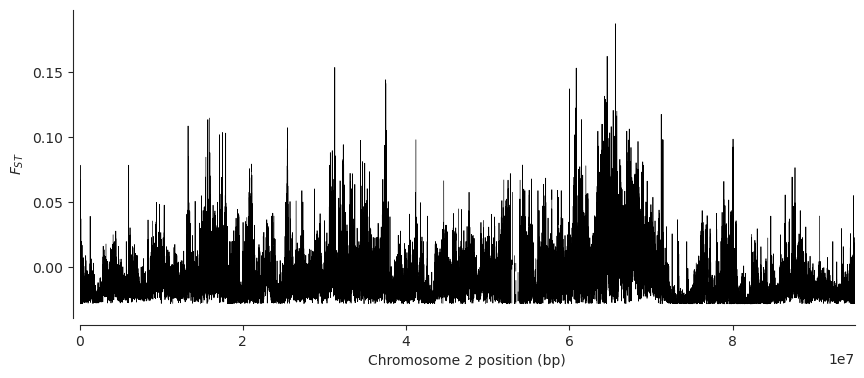

In [15]:
# allel.windowed_patterson_fst(pos, ac1, ac2, size=None, start=None, stop=None, step=None, windows=None, fill=nan)
# if want to use weir and cockerham can do:
# allel.windowed_weir_cockerham_fst(pos, g, subpops, size=None, start=None, stop=None, step=None, windows=None, fill=nan, max_allele=None)
print("Plotting Fst using allel.windowed_patterson_fst, window size 1000")

# fst, windows, counts = allel.windowed_weir_cockerham_fst(pos, genotype, subpoplist, size=1000)    # use the per-block average Fst as the Y coordinate
real_fst, real_windows, counts = allel.windowed_patterson_fst(pos, ac1, ac2, size=1000)    # use the per-block average Fst as the Y coordinate
real_y = real_fst
real_x = [np.mean(w) for w in real_windows]

# plot fst against chromosome position (bp)
fig, ax = plt.subplots(figsize=(10, 4))
sns.despine(ax=ax, offset=5)
ax.plot(real_x, real_y, 'k-', lw=.5)
ax.set_ylabel('$F_{ST}$')
ax.set_xlabel(f'Chromosome {chromosome} position (bp)')
ax.set_xlim(0, pos.max())
print("Number of Fst values:", len(real_x))
print("Number of windows:", len(real_y))

# save fst figure
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
filename = f'fst_windowed_patterson_1000bp_{chromosome}_{pop1}_{pop2}_no_iterations.png'
plt.savefig(filename)
print("Saving windowed Fst plot")

Saving histogram of Fst plot


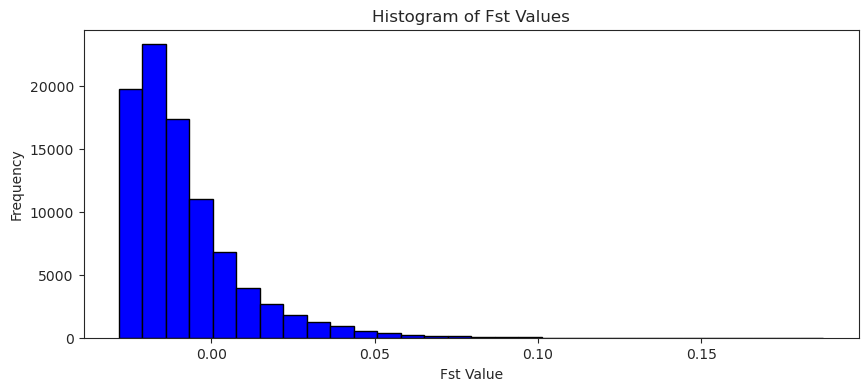

In [16]:
y = real_fst
# create histogram
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(real_y, bins=30, color='blue', edgecolor='black')  # You can adjust the number of bins as needed
ax.set_title('Histogram of Fst Values')
ax.set_xlabel('Fst Value')
ax.set_ylabel('Frequency')
# save this figure
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
filename = f'fst_histogram_windowed_patterson_1000bp_{chromosome}_{pop1}_{pop2}.png'
plt.savefig(filename)
print("Saving histogram of Fst plot")

In [17]:
# Zip together windows and fst values
zipped_windows_real_fst = list(zip(real_windows, real_fst))
# Find the maximum fst value and its corresponding window
max_fst_window = max(zipped_windows_real_fst, key=lambda real_x: real_x[1])
max_window, max_fst = max_fst_window
# Find the minimum fst value and its corresponding window
min_fst_window = min(zipped_windows_real_fst, key=lambda real_x: real_x[1])
min_window, min_fst = min_fst_window
# Printing or further processing
print(f"Maximum Fst value: {max_fst}, Window: {max_window}")
print(f"Minimum Fst value: {min_fst}, Window: {min_window}")

Maximum Fst value: 0.1874289767586621, Window: [65621606 65622605]
Minimum Fst value: -0.028340297867780997, Window: [75623606 75624605]


In [19]:
hist_fst_threshold = (min_fst*3)*-1
print("Threshold for positive value being significant is:",hist_fst_threshold)

Threshold for positive value being significant is: 0.08502089360334299


In [20]:
hist_fst_threshold = [(window,value) for window, value in zip(real_windows, real_fst) if value >= hist_fst_threshold]
if hist_fst_threshold:
    with open(f'fst_values_over_hist_threshold_{pop1}_{pop2}_chromosome_{chromosome}_window_size_1000.csv', 'w') as fst_file:
        # Writing the header
        fst_file.write("Window_Start,Window_End,FST_Value\n")
        
        # Writing data
        for window, value in hist_fst_threshold:
            fst_file.write(f"{window[0]},{window[1]},{value}\n")
    
    print("Saved FST values over histogram threshold")
else:
    print("No FST values over the histogram threshold were found")
    sys.exit() #this will stop the script if there are no Fst values over the histogram threshold for noise

Saved FST values over histogram threshold


In [21]:
permuted_fst_values = []
for i in range(10):
    # Get the indices from df_samples
    df_res_sus_samples = df_samples[df_samples.pyrethroid_resistance_status.isin(['resistant', 'susceptible'])]
    indices = df_res_sus_samples.index.tolist()
    # Shuffle the indices
    np.random.shuffle(indices)
    # Split the indices into two groups
    half_length = len(indices) // 2
    pop1_indices = indices[:half_length]
    pop2_indices = indices[half_length:]
    subpops = {
        'permutation_pop1': pop1_indices,
        'permutation_pop2': pop2_indices,
    }
    permutation_pop1 = 'permutation_pop1'
    permutation_pop2 = 'permutation_pop2'
    # get allele counts
    acs = genotype_all.count_alleles_subpops(subpops)
    # filter variants out if not segregating or not biallelic     
    acu = allel.AlleleCountsArray(acs[permutation_pop1][:] + acs[permutation_pop2][:])
    flt = acu.is_segregating() & (acu.max_allele() == 1)
    # create the new genotype array
    pos = pos_all.compress(flt)
    ac1 = allel.AlleleCountsArray(acs[permutation_pop1].compress(flt, axis=0)[:, :2])
    ac2 = allel.AlleleCountsArray(acs[permutation_pop2].compress(flt, axis=0)[:, :2])
    genotype = genotype_all.compress(flt, axis=0)
    genotype
    # check that pos and genotype are the same size
    if len(pos)==len(genotype):
        print("Length of positions and genotypes in the genotype array are the same, script continuing")
    else:
        print("Something is wrong with the genotype_all array as the length of pos_all and genotype_all are different. Stopping script.")
        sys.exit()  # This will stop the script. If you want the script to continue anyway, # out this line
    
    # Calcalate and plot fst using windowed patterson fst
    fst, windows, counts = allel.windowed_patterson_fst(pos, ac1, ac2, size=1000)   # use the per-block average Fst as the Y coordinate
    print(f"Calculated fst using allel.windowed_patterson_fst, window size 1000 for permutation {i}")
    # Store Fst values for this iteration
    permuted_fst_values.append((windows,fst))
# Notify of finishing permutations
print("Permutations calculated")

Length of positions and genotypes in the genotype array are the same, script continuing
Calculated fst using allel.windowed_patterson_fst, window size 1000 for permutation 0
Length of positions and genotypes in the genotype array are the same, script continuing
Calculated fst using allel.windowed_patterson_fst, window size 1000 for permutation 1
Length of positions and genotypes in the genotype array are the same, script continuing
Calculated fst using allel.windowed_patterson_fst, window size 1000 for permutation 2
Length of positions and genotypes in the genotype array are the same, script continuing
Calculated fst using allel.windowed_patterson_fst, window size 1000 for permutation 3
Length of positions and genotypes in the genotype array are the same, script continuing
Calculated fst using allel.windowed_patterson_fst, window size 1000 for permutation 4
Length of positions and genotypes in the genotype array are the same, script continuing
Calculated fst using allel.windowed_patter

In [22]:
permuted_fst_values = []
for i in range(200):
    # Get the indices from df_samples
    df_res_sus_samples = df_samples[df_samples.pyrethroid_resistance_status.isin(['resistant', 'susceptible'])]
    indices = df_res_sus_samples.index.tolist()
    # Shuffle the indices
    np.random.shuffle(indices)
    # Split the indices into two groups
    half_length = len(indices) // 2
    pop1_indices = indices[:half_length]
    pop2_indices = indices[half_length:]
    subpops = {
        'permutation_pop1': pop1_indices,
        'permutation_pop2': pop2_indices,
    }
    permutation_pop1 = 'permutation_pop1'
    permutation_pop2 = 'permutation_pop2'
    # get allele counts
    acs = genotype_all.count_alleles_subpops(subpops)
    # filter variants out if not segregating or not biallelic     
    acu = allel.AlleleCountsArray(acs[permutation_pop1][:] + acs[permutation_pop2][:])
    flt = acu.is_segregating() & (acu.max_allele() == 1)
    # create the new genotype array
    pos = pos_all.compress(flt)
    ac1 = allel.AlleleCountsArray(acs[permutation_pop1].compress(flt, axis=0)[:, :2])
    ac2 = allel.AlleleCountsArray(acs[permutation_pop2].compress(flt, axis=0)[:, :2])
    genotype = genotype_all.compress(flt, axis=0)
    genotype
    # check that pos and genotype are the same size
    if len(pos)==len(genotype):
        print("Length of positions and genotypes in the genotype array are the same, script continuing")
    else:
        print("Something is wrong with the genotype_all array as the length of pos_all and genotype_all are different. Stopping script.")
        sys.exit()  # This will stop the script. If you want the script to continue anyway, # out this line
    
    # Calcalate and plot fst using windowed patterson fst
    fst, windows, counts = allel.windowed_patterson_fst(pos, ac1, ac2, size=1000)   # use the per-block average Fst as the Y coordinate
    print(f"Calculated fst using allel.windowed_patterson_fst, window size 1000 for permutation {i}")
    # Store Fst values for this iteration
    permuted_fst_values.append((windows,fst))
# Notify of finishing permutations
print("Permutations calculated")

Length of positions and genotypes in the genotype array are the same, script continuing
Calculated fst using allel.windowed_patterson_fst, window size 1000 for permutation 0
Length of positions and genotypes in the genotype array are the same, script continuing
Calculated fst using allel.windowed_patterson_fst, window size 1000 for permutation 1
Length of positions and genotypes in the genotype array are the same, script continuing
Calculated fst using allel.windowed_patterson_fst, window size 1000 for permutation 2
Length of positions and genotypes in the genotype array are the same, script continuing
Calculated fst using allel.windowed_patterson_fst, window size 1000 for permutation 3
Length of positions and genotypes in the genotype array are the same, script continuing
Calculated fst using allel.windowed_patterson_fst, window size 1000 for permutation 4
Length of positions and genotypes in the genotype array are the same, script continuing
Calculated fst using allel.windowed_patter

In [23]:
permuted_fst_values_df = pd.DataFrame(permuted_fst_values)
# Save permuted_fst_values as a csv so that you do not need to calculate again if taking a break in analysis
permuted_fst_values_df.to_csv(f'permuted_fst_values_{pop1}_{pop2}_{chromosome}.csv', index=False)

<ipython-input-24-2140d564eec2>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(x, fst, 'k-', lw=.5, color='grey', alpha=0.5)  # grey color


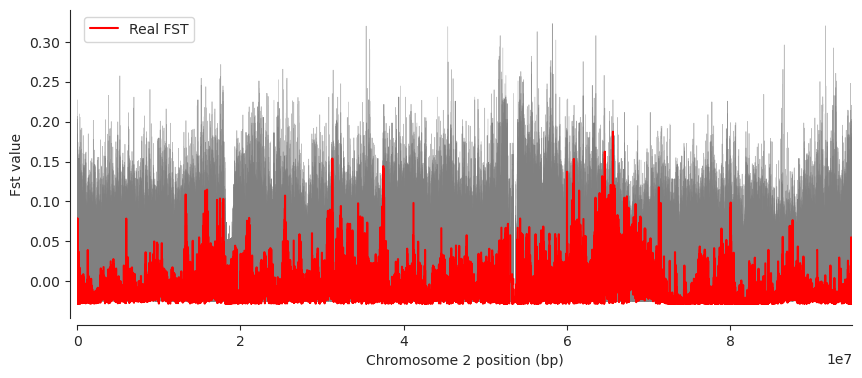

In [24]:
fig, ax = plt.subplots(figsize=(10,4))
sns.despine(ax=ax, offset=5)
# Plot each set of permuted Fst values in grey
for windows,fst in permuted_fst_values:
    x = [np.mean(w) for w in windows]
    ax.plot(x, fst, 'k-', lw=.5, color='grey', alpha=0.5)  # grey color
# Plot real fst values in red
ax.plot(real_x, real_fst, 'r-', lw=1.5, label='Real FST')  # 'r-' for red line

ax.set_ylabel('Fst value')
ax.set_xlabel(f'Chromosome {chromosome} position (bp)')
ax.set_xlim(0, pos.max())
plt.legend()
plt.savefig('combined_fst_permutations_plot.png')
plt.show()

In [27]:
# Initialize an array to store the 99th percentile and window information
percentile_99th_values = []
# Number of windows
num_windows = len(permuted_fst_values[0][0])
# Iterate over each window
for i in range(num_windows):
    # Gather Fst values for this window from each permutation
    fst_values_for_window = [permuted[1][i] for permuted in permuted_fst_values]
    # Ignore NaN values in the percentile calculation
    fst_values_for_window = [value for value in fst_values_for_window if not np.isnan(value)]
    # Calculate the 99th percentile for this window
    percentile_99th = np.percentile(fst_values_for_window, 99) if fst_values_for_window else np.nan
    # Get the window boundaries
    window_boundaries = permuted_fst_values[0][0][i]
    # Store the window and the 99th percentile value as a tuple containing window_boundaries and 99th percentile value
    percentile_99th_values.append((window_boundaries, percentile_99th))
# Notify
print("Calculated 99th percentile values")
# percentile_99th_values now contains each window, and then the value of the 99th percentile of that window

Calculated 99th percentile values


In [28]:
# The 'real_fst' values that are above the histogram threshold for significance are saved in fst_values_over_hist_threshold_...txt
# read in these fst values

real_fst_values_over_hist_threshold = pd.read_csv(f'fst_values_over_hist_threshold_{pop1}_{pop2}_chromosome_{chromosome}_window_size_1000.csv')
print(f"Look at what we made earlier! Read in the csv of real fst values which are above histogram threshold for significance, which you made earlier")
values_over_hist = len(real_fst_values_over_hist_threshold)
print(f"The number of fst values over the histogram threshold for significance is: {values_over_hist}")

Look at what we made earlier! Read in the csv of real fst values which are above histogram threshold for significance, which you made earlier
The number of fst values over the histogram threshold for significance is: 138


In [29]:
# Check if any of the real Fst values are above the 99th percentile value for each window
# to do this, I need to compare zipped_windows_fst with percentile_99th_values
# need to check if the value for Fst in zipped_windows_fst is greater than the percentile_99 in the percentile_99th_values list

print("Now check if any of these real fst values, which were above the histogram threshold, are also above the 99th percentile for the permutations of that window")
# Initialize an empty list to store the data
hist_99_significant_data = []

# Iterate through each row in filtered_df
for index, row in real_fst_values_over_hist_threshold.iterrows():
    window = (row['Window_Start'], row['Window_End'])
    real_fst_value = row['FST_Value']

    # Find the corresponding 99th percentile value for the window
    for window_percentile_values in percentile_99th_values:
        percentile_window, percentile_99th = window_percentile_values
        if np.array_equal(window, percentile_window):
            # Check if the Fst value is greater than the 99th percentile value
            if real_fst_value > percentile_99th:
                window_str = f"{window[0]}-{window[1]}"
                # Add the significant values to the list as a dictionary
                hist_99_significant_data.append({'Window': window_str, 'Fst Value': real_fst_value, '99th Percentile from permutations': percentile_99th})

# Notify
values_over_99 = len(hist_99_significant_data)
print(f"The number of fst values which are over the hist threshold and over the 99th percentile for that window is: {values_over_99}")
# Create DataFrame from the list
hist_99_significant_values_df = pd.DataFrame(hist_99_significant_data)
# Save to a CSV
hist_99_significant_values_df.to_csv(f'significant_fst_values_hist_99_{pop1}_{pop2}_{chromosome}.csv', index=False)
print("Saved these fst values to a csv called 'significant_fst_values_hist_99_(chrom)")

Now check if any of these real fst values, which were above the histogram threshold, are also above the 99th percentile for the permutations of that window
The number of fst values which are over the hist threshold and over the 99th percentile for that window is: 99
Saved these fst values to a csv called 'significant_fst_values_hist_99_(chrom)


Read in filtered significant fst values from csv


<ipython-input-36-34f356c08c6e>:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(x, fst, 'k-', lw=.5, color='lightgrey', alpha=0.5)


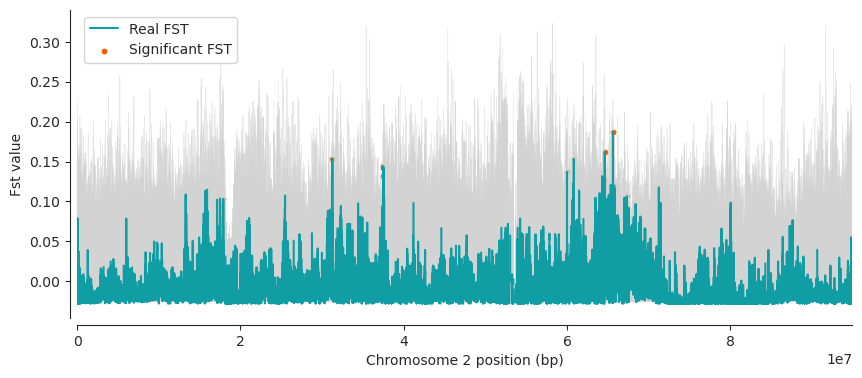

In [36]:
# ## Plot real_fst, permuted_fst and the significant data points which passed the histogram and the 99th percentile thresholds

# Read in the filtered significant values
hist_99_significant_values_df = pd.read_csv(f'significant_fst_values_hist_99_{pop1}_{pop2}_{chromosome}.csv')
print("Read in filtered significant fst values from csv")

# Extract the midpoint of each window for the x-coordinate
hist_99_significant_values_df['Window Midpoint'] = hist_99_significant_values_df['Window'].apply(
    lambda w: np.mean([int(x) for x in w.replace('.0', '').split('-')])
)

# Plotting the combined FST graph with the significant value points highlighted
fig, ax = plt.subplots(figsize=(10, 4))
sns.despine(ax=ax, offset=5)

# Plot each set of permuted Fst values in grey
for windows, fst in permuted_fst_values:
    x = [np.mean(w) for w in windows]
    ax.plot(x, fst, 'k-', lw=.5, color='lightgrey', alpha=0.5)

# Plot real fst values in teal
ax.plot(real_x, real_y, color='#119DA4', lw=1.5, label='Real FST')

# Highlight significant and filtered Fst values with blue dots
ax.scatter(hist_99_significant_values_df['Window Midpoint'], hist_99_significant_values_df['Fst Value'], color='#f35b04', s=10, label='Significant FST')
# Setting labels and title
ax.set_ylabel('Fst value')
ax.set_xlabel(f'Chromosome {chromosome} position (bp)')
ax.set_xlim(0, pos.max())
# Adding legend
plt.legend()
# Save the figure
plt.savefig('combined_fst_permutations_with_highlights_permutations.png')
# Show the plot
plt.show()

Read in filtered significant fst values from csv


<ipython-input-37-f055e10bac55>:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(x, fst, 'k-', lw=.5, color='lightgrey', alpha=0.5)


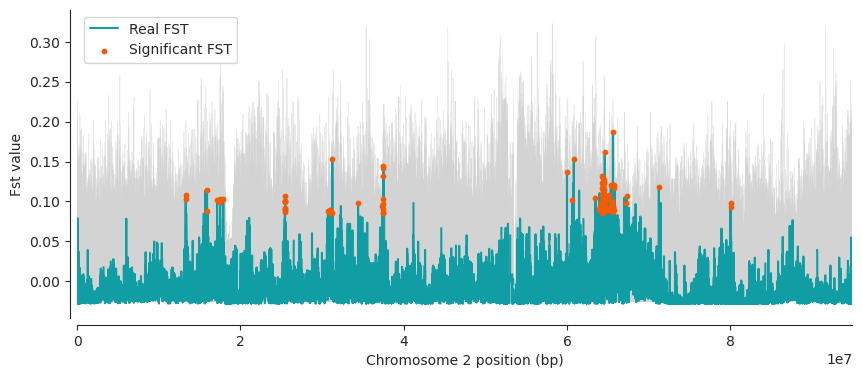

In [37]:
# ## Plot real_fst, permuted_fst and the significant data points which passed the histogram and the 99th percentile thresholds

# Read in the filtered significant values
hist_99_significant_values_df = pd.read_csv(f'significant_fst_values_hist_99_{pop1}_{pop2}_{chromosome}.csv')
print("Read in filtered significant fst values from csv")

# Extract the midpoint of each window for the x-coordinate
hist_99_significant_values_df['Window Midpoint'] = hist_99_significant_values_df['Window'].apply(
    lambda w: np.mean([int(x) for x in w.replace('.0', '').split('-')])
)

# Plotting the combined FST graph with the significant value points highlighted
fig, ax = plt.subplots(figsize=(10, 4))
sns.despine(ax=ax, offset=5)

# Plot each set of permuted Fst values in grey
for windows, fst in permuted_fst_values:
    x = [np.mean(w) for w in windows]
    ax.plot(x, fst, 'k-', lw=.5, color='lightgrey', alpha=0.5)

# Plot real fst values in teal
ax.plot(real_x, real_y, color='#119DA4', lw=1.5, label='Real FST')

# Highlight significant and filtered Fst values with orange dots
ax.scatter(hist_99_significant_values_df['Window Midpoint'], 
           hist_99_significant_values_df['Fst Value'],
             color='#f35b04',
               s=10,
                 label='Significant FST',
                 zorder=3)

# Setting labels and title
ax.set_ylabel('Fst value')
ax.set_xlabel(f'Chromosome {chromosome} position (bp)')
ax.set_xlim(0, pos.max())
# Adding legend
plt.legend()
# Save the figure
plt.savefig('combined_fst_permutations_with_highlights_permutations.png')
# Show the plot
plt.show()